In [2]:
#uncomment line below and run if not yet installed
#! pip install scikit-learn-extra

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")
import math

## Additional imports can be inlcuded here
from  sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn_extra.cluster import KMedoids
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder


In [164]:
norm = pd.read_csv('../Merging/Merge_Raw.csv')
norm.head()
len(norm)

503

In [3]:
def make_pds (norm=None, dezero=None, norm_vis=None):
    '''Input: norm - if True, then the consumption values for each plant will be normalized
        dezero - if True, then removes all plants that have a value of 0 consumption at some point
        norm_vis - if True, then uses normalized time series for result (visualization) dataframe
    Output: a matrix df and a results df that has timeseries and location data for each plant'''
    if norm and dezero:
        dmatrix = pd.read_csv('../Merging/DTW_Matrix_Norm_No0.csv')
    elif norm:
        dmatrix = pd.read_csv('../Merging/DTW_Matrix_Norm.csv')
    elif dezero:
        dmatrix = pd.read_csv('../Merging/DTW_Matrix_Raw_No0.csv')
    else:
        dmatrix = pd.read_csv('../Merging/DTW_Matrix_Raw.csv')
        
    if norm_vis:
        results = pd.read_csv('../Merging/Merge_Norm.csv')
    else:
        results = pd.read_csv('../Merging/Merge_Raw.csv')
    
    return dmatrix, results

In [52]:
def hierarchical_cluster (dmatrix, k=None, d_thresh=None, encode=True):
    '''Input: K number of clusters to make, and a distance matrix
    Output: df with cluster labels and plant codes'''
    
    model = AgglomerativeClustering(metric='precomputed', n_clusters=k, distance_threshold = d_thresh,
                                    linkage='complete').fit(dmatrix)
    labels = model.labels_
    if not k:
        k = len(np.unique(labels))
        
    if d_thresh:
        distance = model.distances_
        children = model.children_
    
    encoder = OneHotEncoder(sparse_output=False)
    onehot = encoder.fit_transform(labels.reshape(-1, 1))
    headers = [f'H{k}_{x}' for x in range(k)]
    
    
    if encode:
        results  = pd.DataFrame(data=onehot, columns = headers)
    else:
        results = pd.DataFrame(data=labels, columns = ['labels'])
        #pd.concat([pd.Series(dmatrix.columns,name='plantCode'),results], axis=1)
        #results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results#, distance, children

In [69]:
def DBSCAN_cluster(dmatrix, eps=0.5, min_samples=5, encode=True):
    '''Input: K number of clusters to make, and a distance matrix
    Output: df with cluster labels and plant codes'''
    
    model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dmatrix)
    labels = model.labels_
    k = len(np.unique(labels))
    results = pd.DataFrame(data=[labels, dmatrix.columns]).T

    encoder = OneHotEncoder(sparse_output=False)
    onehot = encoder.fit_transform(labels.reshape(-1, 1))
    headers = [f'DB{k}_{x}' for x in range(k)]

    if encode:
        results  = pd.DataFrame(data=onehot, columns = headers)
    else:
        results.columns=[f'{k}_Clusters','plantCode'] 
        results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results

In [150]:
def AffinityProp_cluster(dmatrix, damping=.9, max_iter=15, encode=True):
    '''Input: distance matrix, dampening [.5,1] and max_iter values
    Output: df with cluster labels and plant codes'''
    #affinity is metric in newer scikit learn versions
    
    model = AffinityPropagation(damping=damping, max_iter=max_iter, affinity='precomputed',random_state=0).fit(dmatrix)
    labels = model.labels_
    k = len(np.unique(labels))

    encoder = OneHotEncoder(sparse_output=False)
    onehot = encoder.fit_transform(labels.reshape(-1, 1))
    headers = [f'AP{k}_{x}' for x in range(k)]

    if encode:
        results  = pd.DataFrame(data=onehot, columns = headers)
    else:
        results = pd.DataFrame(data=[labels, dmatrix.columns]).T
        results.columns=[f'{k}_Clusters','plantCode'] 
        results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results

In [151]:
def kMediods_cluster (dmatrix, k=8, encode=True):
    '''Input: K number of clusters to make, and a distance matrix
    Output: df with cluster labels and plant codes'''
    
    model = KMedoids(n_clusters=k, random_state=0, metric='precomputed').fit(dmatrix)
    labels = model.labels_
    inertia = model.inertia_
    
    encoder = OneHotEncoder(sparse_output=False)
    onehot = encoder.fit_transform(labels.reshape(-1, 1))
    headers = [f'KM{k}_{x}' for x in range(k)]
    
    if encode:
        results = pd.DataFrame(data=onehot, columns = headers)
    else:
        results = pd.concat([pd.Series(dmatrix.columns,name='plantCode'),results], axis=1)
        results['plantCode'] = results['plantCode'].astype(np.int64)

    
    return results

In [197]:
def raw_and_norm (K=None, norm = None, dzero=False):

    results_dict = {}
    dmatrix, _ = make_pds (norm=norm, dezero=dzero)

    for k in range(2,K):
        
        for n in range(2):
            if n == 0:
                results = kMediods_cluster (dmatrix, k=k, encode = True)
                d = 'KM'
            else:
                results = hierarchical_cluster (dmatrix, k=k, encode=True)
                d = 'H'
            results = pd.concat([pd.Series(dmatrix.columns,name='plantCode'),results], axis=1)
            results['plantCode'] = results['plantCode'].astype(np.int64)
                
            if norm:
                results.columns = [f'N_{y}' for y in results.columns]
                results_dict[f'N_{d}{k}'] = results
                n = 'Norm'
            else:
                results_dict[f'{d}{k}'] = results
                n = 'Raw'
    if norm: 
        for eps in np.linspace(0.000005,0.001, 20):
            results = DBSCAN_cluster(dmatrix, eps=eps)
            d = 'DB'
            #k = len(np.unique(results.columns))
            results = pd.concat([pd.Series(dmatrix.columns,name='plantCode'),results], axis=1)
            results['plantCode'] = results['plantCode'].astype(np.int64)
            results.columns = [f'N_{y}' for y in results.columns]
            results_dict[f'N_{d}{round(eps,6)}'] = results
    else:
        for eps in np.arange(1000,30000,1000):
            results = DBSCAN_cluster(dmatrix, eps=eps)
            d = 'DB'
            #k = len(np.unique(results.columns))
            results = pd.concat([pd.Series(dmatrix.columns,name='plantCode'),results], axis=1)
            results['plantCode'] = results['plantCode'].astype(np.int64)
            results_dict[f'{d}{round(eps,6)}'] = results 

    results = AffinityProp_cluster(dmatrix)
    d = 'AP'
    k = len(np.unique(results.columns))
    results = pd.concat([pd.Series(dmatrix.columns,name='plantCode'),results], axis=1)
    results['plantCode'] = results['plantCode'].astype(np.int64)
    results_dict[f'{d}{k}'] = results 
                
    pickle.dump(results_dict, open(f"{n}_Plant_Clusters.p", "wb"))              
    
    return results_dict
        

In [189]:
a = np.linspace(0.000005,0.001, 22)
a

array([5.00000000e-06, 5.23809524e-05, 9.97619048e-05, 1.47142857e-04,
       1.94523810e-04, 2.41904762e-04, 2.89285714e-04, 3.36666667e-04,
       3.84047619e-04, 4.31428571e-04, 4.78809524e-04, 5.26190476e-04,
       5.73571429e-04, 6.20952381e-04, 6.68333333e-04, 7.15714286e-04,
       7.63095238e-04, 8.10476190e-04, 8.57857143e-04, 9.05238095e-04,
       9.52619048e-04, 1.00000000e-03])

In [198]:
x = raw_and_norm (K=22, norm = True, dzero=False)
#x['AP1']
x.keys()

dict_keys(['N_KM2', 'N_H2', 'N_KM3', 'N_H3', 'N_KM4', 'N_H4', 'N_KM5', 'N_H5', 'N_KM6', 'N_H6', 'N_KM7', 'N_H7', 'N_KM8', 'N_H8', 'N_KM9', 'N_H9', 'N_KM10', 'N_H10', 'N_KM11', 'N_H11', 'N_KM12', 'N_H12', 'N_KM13', 'N_H13', 'N_KM14', 'N_H14', 'N_KM15', 'N_H15', 'N_KM16', 'N_H16', 'N_KM17', 'N_H17', 'N_KM18', 'N_H18', 'N_KM19', 'N_H19', 'N_KM20', 'N_H20', 'N_KM21', 'N_H21', 'N_DB5e-06', 'N_DB5.7e-05', 'N_DB0.00011', 'N_DB0.000162', 'N_DB0.000214', 'N_DB0.000267', 'N_DB0.000319', 'N_DB0.000372', 'N_DB0.000424', 'N_DB0.000476', 'N_DB0.000529', 'N_DB0.000581', 'N_DB0.000633', 'N_DB0.000686', 'N_DB0.000738', 'N_DB0.000791', 'N_DB0.000843', 'N_DB0.000895', 'N_DB0.000948', 'N_DB0.001', 'AP1'])

In [63]:
x = pd.read_csv('../Merging/DTW_Matrix_Norm.csv')
x.head()

,9,99,136,298,550,564,607,609,612,613,...,66566,66567,66593,66594,66595,66596,66597,66612,66613,66614
0,0.000000,0.008073,0.017852,0.007702,0.011217,0.009357,0.006081,0.008847,0.010760,0.008600,...,0.044256,0.044251,0.044302,0.044265,0.044247,0.044206,0.044246,0.044256,0.044269,0.044246
1,0.008073,0.000000,0.012693,0.003242,0.006174,0.004529,0.005448,0.004085,0.005517,0.004732,...,0.066718,0.066728,0.066733,0.066699,0.066735,0.066731,0.066740,0.066727,0.066730,0.066724
2,0.017852,0.012693,0.000000,0.009603,0.030521,0.006258,0.005549,0.009330,0.006321,0.007624,...,0.049684,0.049691,0.049692,0.049663,0.049697,0.049685,0.049675,0.049689,0.049699,0.049686
3,0.007702,0.003242,0.009603,0.000000,0.010828,0.004084,0.004537,0.003782,0.004843,0.004006,...,0.066015,0.066024,0.066025,0.065994,0.066030,0.066023,0.066017,0.066022,0.066029,0.066019
4,0.011217,0.006174,0.030521,0.010828,0.000000,0.019171,0.015359,0.018963,0.021173,0.010108,...,0.089200,0.089210,0.089207,0.089178,0.089217,0.089212,0.089203,0.089205,0.089212,0.089206


In [152]:
x = raw_and_norm (k=8, d_thresh = None, dzero=False)
x

,plantCode,KM8_0,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,H8_0,H8_1,H8_2,H8_3,H8_4,H8_5,H8_6,H8_7
0,298,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,607,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1702,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1740,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1743,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,7380,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
148,7846,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
149,7873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
150,8048,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def best_k (norm=None, dezero=None, kmax=8, model='hierarchical'):
    
    dmatrix, _ = make_pds (norm=norm, dezero=dezero)
    
    best_k = 0
    best_inertia = 0
    best_results = None
    
    for k in range(1,kmax+1):
        if model =='KMedoids':
            results, inertia = kMediods_cluster(dmatrix, k)
        else:
            results, inertia = hierarchical_cluster (dmatrix, k)
        #if inertia > best_inertia:
        #    best_inertia = inertia
            best_results = results
            best_k = k
            
    return best_k, best_inertia, results

            

In [7]:
def DBSCAN_cluster(dmatrix, eps=0.5, min_samples=5, ):
    '''Input: K number of clusters to make, and a distance matrix
    Output: df with cluster labels and plant codes'''
    
    model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dmatrix)
    labels = model.labels_
    k = len(np.unique(labels))
    results = pd.DataFrame(data=[labels, dmatrix.columns]).T
    results.columns=[f'{k}_Clusters','plantCode'] 
    results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results

In [8]:
def AffinityProp_cluster(dmatrix, damping=.9, max_iter=15):
    '''Input: distance matrix, dampening [.5,1] and max_iter values
    Output: df with cluster labels and plant codes'''
    #affinity is metric in newer scikit learn versions
    
    model = AffinityPropagation(damping=damping, max_iter=max_iter, affinity='precomputed',
                               random_state=0).fit(dmatrix)
    labels = model.labels_
    k = len(np.unique(labels))
    results = pd.DataFrame(data=[labels, dmatrix.columns]).T
    results.columns=[f'{k}_Clusters','plantCode'] 
    results['plantCode'] = results['plantCode'].astype(np.int64)
    
    return results

In [24]:
def distribution_by_state(results, k):
    '''Input: a results data frame and k - the number of clusters sought for
    Output: prints out the breakdown of states for each cluster for each clustering 1 to k'''
    crosstabs = []
    for result in results.columns[-k:]:
        #print(pd.crosstab(results[result],results['state']))
        crosstabs.append(pd.crosstab(results[result],results['state']))
    
    return print([x for x in crosstabs])

In [19]:
def plot_result (results, title='None'):
    fig, [ax1, ax2] = plt.subplots(1,2,figsize=(14, 5))
    colors = ['r','g','b','y','m','c','k', 'orange', 'teal', 'darkorchid']
    
    labels = results.columns[-1]
    k = len(results[labels].unique())
    
    ax1.xaxis.set_ticks([])
    ax2.xaxis.set_ticks([])
    
    for i,state in enumerate(results['state'].unique()):
        ax1.plot(results.query("state==@state").iloc[:,4:-1].T, alpha=.25, color=colors[i])
        ax1.title.set_text('Clustered by State')
    
    for i in range(-1,k-1):
        #return results[results[labels] == i].iloc[:,4:-1].T
        ax2.plot(results[results[labels] == i].iloc[:,4:-1].T, alpha=.25, color=colors[i])
        ax2.title.set_text(f'{title} {k} Clusters')
    
    return plt.show()

In [36]:
def plot_results_k (results, k):
    '''Input: results - df with time series data and k columns with cluster labels
    Output: makes a plot for each clustering by state and k-2 to k'''
    cols = 2
    rows = (k)//2
    
    fig, axs = plt.subplots(rows,cols,figsize=(14, 20))
    colors = ['r','g','b','y','m','c','k', 'orange', 'teal', 'darkorchid']
    
    K_cols = results.columns[-1]
    count = -k
    
    for row in range(rows):
        for col in range(cols):
            axs[row][col].xaxis.set_ticks(np.arange(2019, 2020, 1))
            if count == -k:
                for i,state in enumerate(results['state'].unique()):
                    axs[row][col].plot(results.query("state==@state").iloc[:,4:-k].T, alpha=.25, color=colors[i])
                    axs[row][col].title.set_text('Clustered by State')
                count +=2
            elif count == 0:
                pass
            else:
                k_col = results.columns[count]
                for i in range(0,k+count+1):
                    axs[row][col].plot(results[results[k_col] == i].iloc[:,4:-k].T, alpha=.25, color=colors[i])
                    axs[row][col].title.set_text(f'{k_col}')
                count += 1

    return plt.show()

In [ ]:
def plot_res (results, k):
    '''Input: results - df with time series data and k columns with cluster labels
    Output: makes a plot for each clustering by state and k-2 to k'''
    cols = 2
    rows = (k)//2
    
    fig, axs = plt.subplots(rows,cols,figsize=(14, 20))
    colors = ['r','g','b','y','m','c','k', 'orange', 'teal', 'darkorchid']
    
    K_cols = results.columns[-1]
    count = -k
    
    for row in range(rows):
        for col in range(cols):
            axs[row][col].xaxis.set_ticks(np.arange(2019, 2020, 1))
            if count == -k:
                for i,state in enumerate(results['state'].unique()):
                    axs[row][col].plot(results.query("state==@state").iloc[:,4:-k].T, alpha=.25, color=colors[i])
                    axs[row][col].title.set_text('Clustered by State')
                count +=2
            elif count == 0:
                pass
            else:
                k_col = results.columns[count]
                for i in range(0,k+count+1):
                    axs[row][col].plot(results[results[k_col] == i].iloc[:,4:-k].T, alpha=.25, color=colors[i])
                    axs[row][col].title.set_text(f'{k_col}')
                count += 1

    return plt.show()

In [64]:
def cluster_k_results (norm=None, dezero=None, norm_vis=None, k=6, model='hierarchical',
                      dist=None, plot=None, geoplot=None):
    '''Input: norm - if True, then the consumption values for each plant will be normalized
        dezero - if True, then removes all plants that have a value of 0 consumption at some point
        norm_vis - if True, then uses normalized time series for result (visualization) dataframe
        k - the number of clusters to look for (3-k)
        model - which clustering model to use
    Output: distribution matrix by state, plot, geeplot, or df of the model results for range of k-2 to k labels
        for clustering algorithm'''
    
    dmatrix, results = make_pds (norm=norm, dezero=dezero, norm_vis=norm_vis)
    
    for i in range(1,k+1):
        if model == 'KMediods':
            result = kMediods_cluster (dmatrix, i)
        else:
            result = hierarchical_cluster(dmatrix, i, encode = False)
        results = pd.merge(results, result, how='left', left_on='plantCode', right_on='plantCode')
    
    results = results.dropna()
    
    if dist:
        distribution_by_state(results, k)
        
    if plot:
        return plot_results_k (results, k)
        
    if geoplot:
        return print('not ready yet')
        
    return results
        

In [62]:
def cluster_result (norm=None, dezero=None, norm_vis=None, k=6, model='hierarchical',
                    damping=.05, max_iter=200, eps=0.5, min_samples=5, kH = None, d_thresh=None,
                    dist=None, plot=None, geoplot=None, title=None):
    '''Input: norm - if True, then the consumption values for each plant will be normalized
        dezero - if True, then removes all plants that have a value of 0 consumption at some point
        norm_vis - if True, then uses normalized time series for result (visualization) dataframe
        k - the number of clusters to look for (3-k)
        model - which clustering model to use
    Output: distribution, plot, geoplot, or df of the model results'''
    
    dmatrix, results = make_pds (norm=norm, dezero=dezero, norm_vis=norm_vis)
    
    if model == 'KMediods':
        result = kMediods_cluster (dmatrix, k, plants=True)
    elif model ==  'AffinityProp':
        result = AffinityProp_cluster(dmatrix, damping=damping, max_iter=max_iter)
    elif model == 'DBSCAN':
        result = DBSCAN_cluster(dmatrix, eps=eps, min_samples=min_samples)
    else:
        result = hierarchical_cluster(dmatrix, kH, d_thresh)
    
    results = pd.merge(results, result, how='left', left_on='plantCode', right_on='plantCode')
    
    results = results.dropna()
    
    if dist:
        distribution_by_state(results, 1)
        
    if plot:
        return plot_result (results, title)
        
    if geoplot:
        return print('not ready yet')
        
    return #results

In [59]:
def cluster_k_results (norm=None, dezero=None, norm_vis=None, k=6, model='hierarchical',
                      dist=None, plot=None, geoplot=None):
    '''Input: norm - if True, then the consumption values for each plant will be normalized
        dezero - if True, then removes all plants that have a value of 0 consumption at some point
        norm_vis - if True, then uses normalized time series for result (visualization) dataframe
        k - the number of clusters to look for (3-k)
        model - which clustering model to use
    Output: distribution matrix by state, plot, geeplot, or df of the model results for range of k-2 to k labels
        for clustering algorithm'''
    
    dmatrix, results = make_pds (norm=norm, dezero=dezero, norm_vis=norm_vis)
    
    for i in range(1,k+1):
        if model == 'KMediods':
            result = kMediods_cluster (dmatrix, i)
        else:
            result = hierarchical_cluster(dmatrix, i, encode=False)
        results = pd.merge(results, result, how='left', left_on='plantCode', right_on='plantCode')
    
    results = results.dropna()
    
    if dist:
        distribution_by_state(results, k)
        
    if plot:
        return plot_results_k (results, k)
        
    if geoplot:
        return print('not ready yet')
        
    return #results
        

In [54]:
print('Hierarchical Clustering: Raw Data, All values, Raw Data Visualization')
results = cluster_result (norm=True, dezero=None, norm_vis=False, k=9, model='hierarchical', kH=9, d_thresh=None, 
                           dist=True, plot=True)

Hierarchical Clustering: Raw Data, All values, Raw Data Visualization


TypeError: hierarchical_cluster() got an unexpected keyword argument 'plants'

In [65]:
print('Hierarchical Clustering: Raw Data, All values, Raw Data Visualization')
results = cluster_k_results (norm=True, dezero=None, norm_vis=None, k=7, model='hierarchical', plot=True)

Hierarchical Clustering: Raw Data, All values, Raw Data Visualization


KeyError: 'plantCode'

In [61]:
print('Hierarchical Clustering: Normalized Data, All values, Raw Data Visualization')
results = cluster_k_results (norm=True, dezero=None, norm_vis=None, k=7, model='hierarchical', plot=True)

Hierarchical Clustering: Normalized Data, All values, Raw Data Visualization


KeyError: 'plantCode'

In [9]:
print('Hierarchical Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization')
#results = cluster_k_results (norm=True, dezero=True, norm_vis=None, k=7, model='hierarchical', geoplot=True)

Hierarchical Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization


In [8]:
print('Hierarchical Clustering: Raw Data, Zeros Dropped, Raw Data Visualization')
#results = cluster_k_results (norm=False, dezero=True, norm_vis=None, k=7, model='hierarchical', geoplot=True)

Hierarchical Clustering: Raw Data, Zeros Dropped, Raw Data Visualization


In [7]:
print('Hierarchical Clustering: Normalized Data, Zeros Dropped, Normalized Visualization')
#results = cluster_k_results (norm=True, dezero=True, norm_vis=True, k=7, model='hierarchical', geoplot=True)

Hierarchical Clustering: Normalized Data, Zeros Dropped, Normalized Visualization


KMediod Clustering: Normalized Data, Zeros Dropped, Normalized Visualization


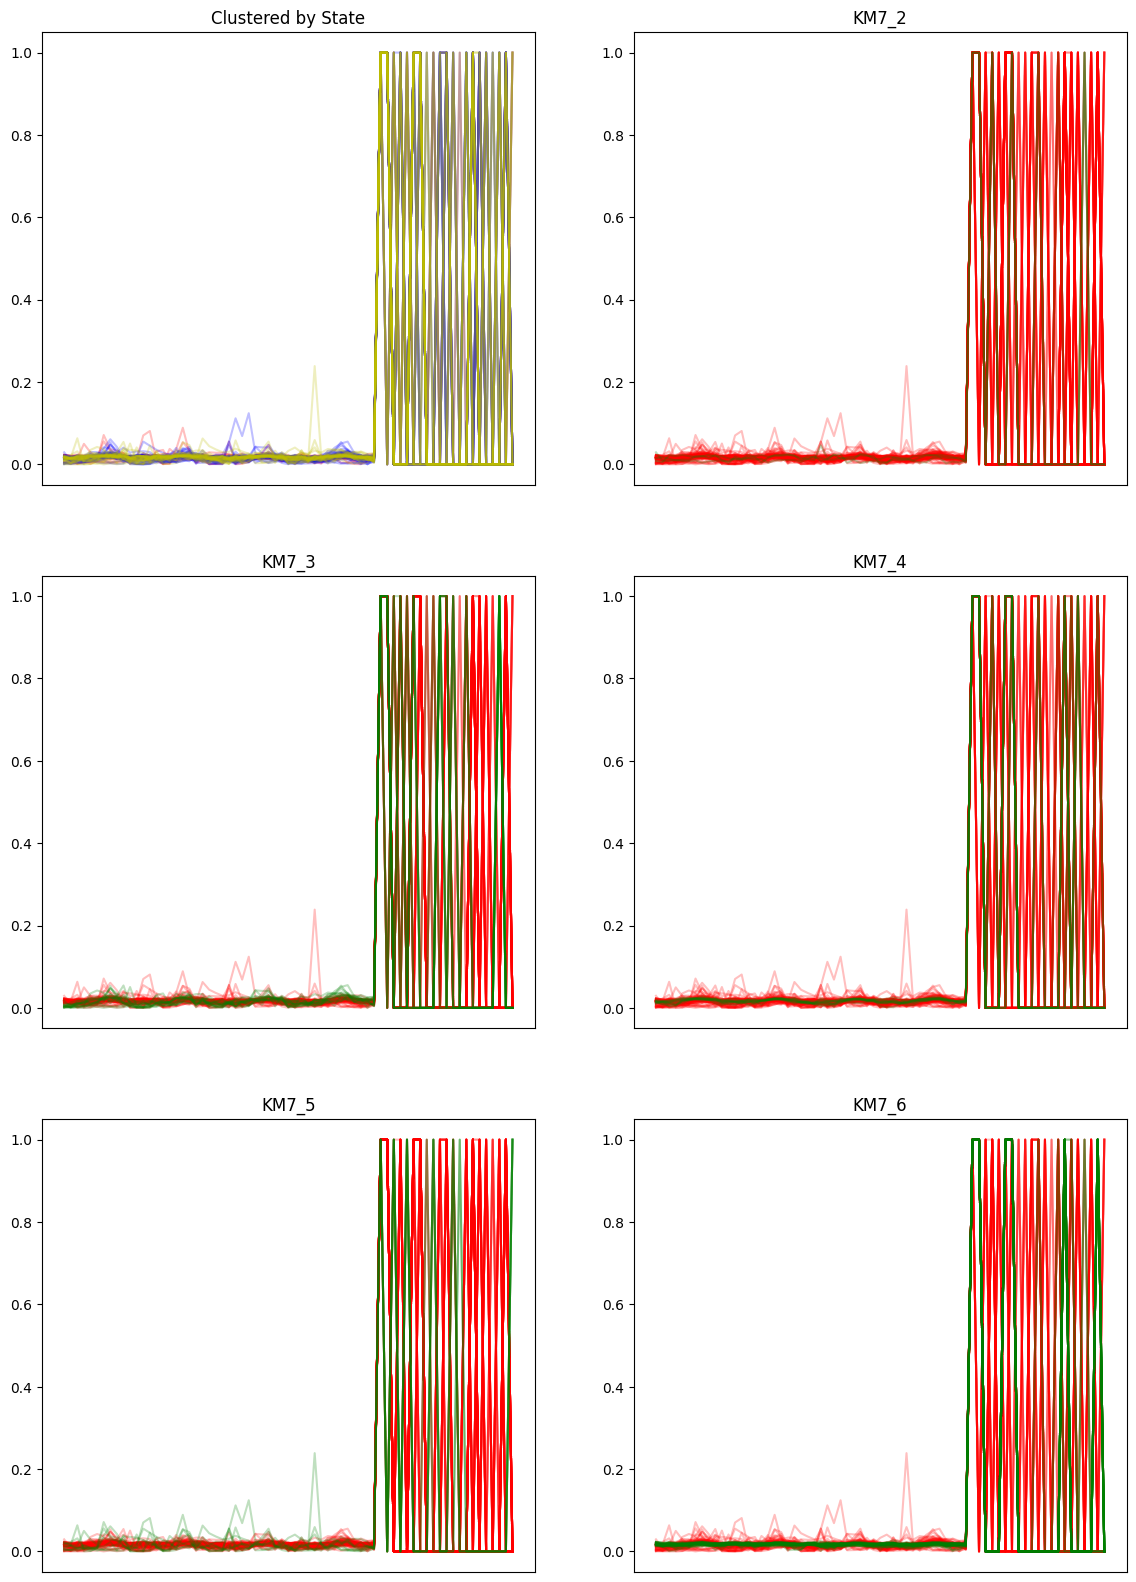

In [58]:
print('KMediod Clustering: Normalized Data, Zeros Dropped, Normalized Visualization')
results = cluster_k_results (norm=True, dezero=True, norm_vis=True, k=7, model='KMediods', plot=True)

In [5]:
print('KMediod Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization')
#results = cluster_k_results (norm=True, dezero=True, norm_vis=False, k=7, model='KMediods', geoplot=True)

KMediod Clustering: Normalized Data, Zeros Dropped, Raw Data Visualization


In [3]:
print('KMediod Clustering: Raw Data, Zeros Dropped, Raw Data Visualization')
#results = cluster_k_results (norm=False, dezero=True, norm_vis=False, k=7, model='KMediods', geoplot=True)

KMediod Clustering: Raw Data, Zeros Dropped, Raw Data Visualization


In [2]:
print('KMediod Clustering: Normalized Data, All Data, Raw Data Visualization')
#results = cluster_k_results (norm=True, dezero=False, norm_vis=False, k=7, model='KMediods', geoplot=True)


KMediod Clustering: Normalized Data, All Data, Raw Data Visualization


In [1]:
print('KMediod Clustering: Raw Data, All Data, Raw Data Visualization')
#results = cluster_k_results (norm=False, dezero=True, norm_vis=False, k=7, model='KMediods', geoplot=True)

KMediod Clustering: Raw Data, All Data, Raw Data Visualization


In [7]:
x = pd.DataFrame([['cat',3,4,5],['dog',3,4,5]], columns = ['m', 'n','c','f'])
x.head()

,m,n,c,f
0,cat,3,4,5
1,dog,3,4,5


In [11]:
x2 = pd.DataFrame([['cat',3,4,5],['dog',3,4,5]], columns = ['m', 'n','c','f'])
x.iloc[1,1] = x2
a = x.iloc[1,1]
a
x.head()
x2.head()

,m,n,c,f
0,cat,3,4,5
1,dog,3,4,5
